In [1]:
!pip install opendatasets

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/download?datasetVersionNumber=1")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omarali13
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


In [4]:
# Constants
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 50
NUM_CLASSES = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set paths
base_path = "./brain-mri-images-for-brain-tumor-detection"
path_class_yes = os.path.join(base_path, "yes")
path_class_no = os.path.join(base_path, "no")

In [5]:
# Dataset Class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Grayscale
        label = torch.tensor(self.labels[idx])

        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# Load image paths and labels
image_paths_yes = [os.path.join(path_class_yes, img) for img in os.listdir(path_class_yes)]
labels_yes = [1] * len(image_paths_yes)

image_paths_no = [os.path.join(path_class_no, img) for img in os.listdir(path_class_no)]
labels_no = [0] * len(image_paths_no)

all_image_paths = image_paths_yes + image_paths_no
all_labels = labels_yes + labels_no

In [7]:
# Split into train, val, test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1, random_state=42, stratify=train_labels
)

In [8]:
# Define transforms
target_size = (224, 224)
train_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
])

In [9]:
# Datasets and Dataloaders
train_dataset = CustomDataset(train_paths, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = CustomDataset(test_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

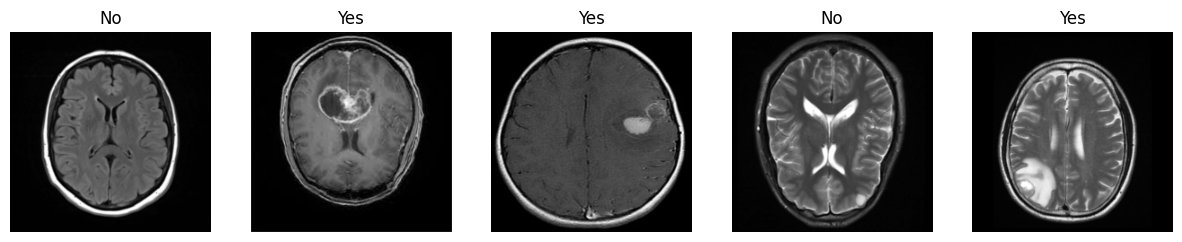

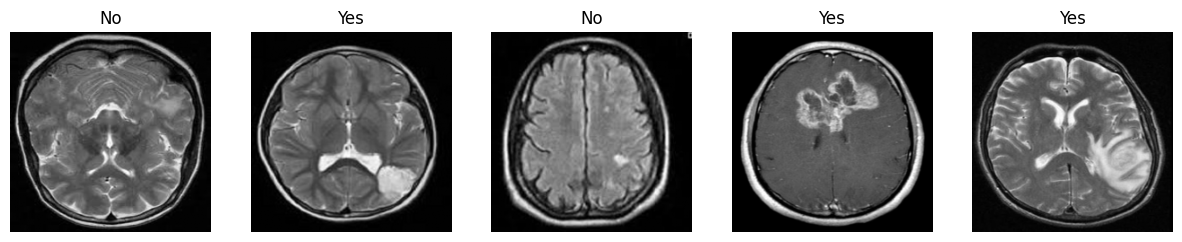

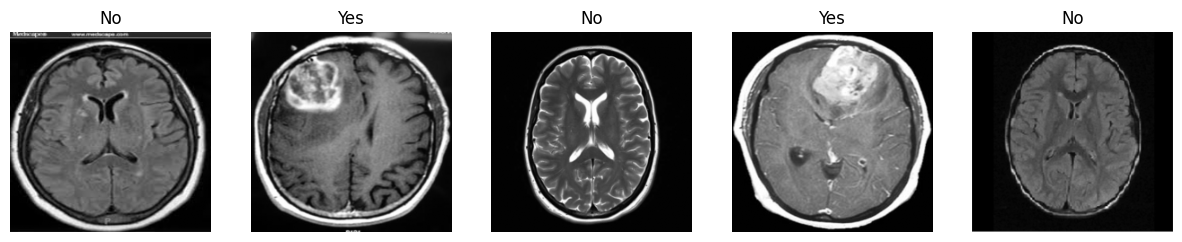

In [10]:
# Visualize function
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(transforms.ToPILImage()(img), cmap='gray')
        axes[i].set_title("Yes" if label.item() == 1 else "No")
        axes[i].axis('off')
    plt.show()

visualize_samples(train_dataset)
visualize_samples(val_dataset)
visualize_samples(test_dataset)

In [11]:
# Load model
model = timm.create_model(
    'swin_base_patch4_window7_224',
    pretrained=True,
    num_classes=NUM_CLASSES,
    in_chans=1
)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = F.cross_entropy

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [12]:
# Accuracy Function
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, total = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            correct_pred += (predicted == targets).sum().item()
            total += targets.size(0)
    return 100 * correct_pred / total

In [13]:
# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    training_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            val_loss += loss_function(outputs, labels).item()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {training_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1/50 | Train Loss: 0.6460 | Val Loss: 0.5953
Epoch 2/50 | Train Loss: 0.3537 | Val Loss: 0.9917
Epoch 3/50 | Train Loss: 0.2628 | Val Loss: 0.2773
Epoch 4/50 | Train Loss: 0.1833 | Val Loss: 0.2158
Epoch 5/50 | Train Loss: 0.1461 | Val Loss: 0.2805
Epoch 6/50 | Train Loss: 0.0849 | Val Loss: 0.0787
Epoch 7/50 | Train Loss: 0.0849 | Val Loss: 0.3323
Epoch 8/50 | Train Loss: 0.0768 | Val Loss: 0.5839
Epoch 9/50 | Train Loss: 0.0269 | Val Loss: 0.3992
Epoch 10/50 | Train Loss: 0.0592 | Val Loss: 0.5545
Epoch 11/50 | Train Loss: 0.0460 | Val Loss: 0.5360
Epoch 12/50 | Train Loss: 0.0973 | Val Loss: 0.3468
Epoch 13/50 | Train Loss: 0.1244 | Val Loss: 0.1122
Epoch 14/50 | Train Loss: 0.0269 | Val Loss: 0.0515
Epoch 15/50 | Train Loss: 0.0243 | Val Loss: 0.4629
Epoch 16/50 | Train Loss: 0.0074 | Val Loss: 0.0659
Epoch 17/50 | Train Loss: 0.0022 | Val Loss: 0.0259
Epoch 18/50 | Train Loss: 0.0003 | Val Loss: 0.0466
Epoch 19/50 | Train Loss: 0.0018 | Val Loss: 0.0062
Epoch 20/50 | Train L

In [14]:
# Test accuracy
test_acc = compute_accuracy(model, test_loader, DEVICE)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 96.08%


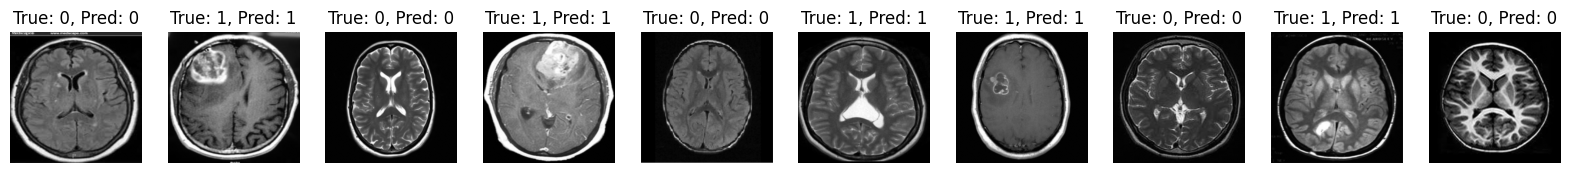

In [15]:
# Prediction visualization
def visualize_predictions(dataset, model, device, num_samples=10):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(1, num_samples, figsize=(20, 3))
        for i in range(num_samples):
            image, label = dataset[i]
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            axes[i].imshow(transforms.ToPILImage()(image), cmap='gray')
            axes[i].set_title(f"True: {label}, Pred: {predicted.item()}")
            axes[i].axis('off')
        plt.show()

visualize_predictions(test_dataset, model, DEVICE)

In [16]:
# Save and load model
torch.save(model.state_dict(), 'model.pth')

model_cpu = timm.create_model(
    'swin_base_patch4_window7_224',
    pretrained=False,
    num_classes=NUM_CLASSES,
    in_chans=1
)
model_cpu.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))
model_cpu.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (